# COSMIC VARIANCE

In [2]:
import numpy as np
# for convenience for power spectrum
import halomod
import hmf
from halomod import DMHaloModel,TracerHaloModel
import matplotlib.pyplot as plt

%matplotlib inline
plt.rc('font',**{'family':'serif','size':14})
#plt.rc('text', usetex=True)

In [3]:
from astropy.cosmology import Planck15
#from astropy.cosmology import WMAP3 as cosmo
from astropy.cosmology import FlatLambdaCDM
# this is the cosmology used in Moster et al. (2010), but the quickcv code over-rules some things
cosmo = FlatLambdaCDM(H0=72, Om0=0.26, Tcmb0=2.725)
sig8 = 0.77
# 0.77 is WMAP3
# 0.829 is Planck15
# 06 is the value given in Newman & Davis (2002), for r0 = 3.25
ns = 0.95


## QuickCV translation 

In [4]:
def pofk(karr, n=1, gamma=0.21):
    # this is the power spectrum function translated from quickcv IDL code 
    
    omega0 = 0.3 # this value is forced in the code, I guess to be consistent with the Borgani rescaling???
    sigma8 = 0.58*omega0**(-0.47+0.16*omega0)
    h = 1. 
    
    # following Peacock, p. 528

    keff = (0.172+0.011*(np.log(gamma/0.34))**2) 
    q = keff/(h*gamma)
    tk = np.log(1+2.34*q)/(2.34*q)*(1+3.89*q+(16.1*q)**2+(5.46*q)**3+(6.71*q)**4)**(-0.25)
    sigma8squn = keff**(3+n)*tk**2

    q = karr/(h*gamma)   # k/h Gamma
    tk = np.log(1+2.34*q)/(2.34*q)*(1+3.89*q+(16.1*q)**2+(5.46*q)**3+(6.71*q)**4)**(-0.25)
    delsq = karr**n*tk**2       # took out factor of k^3
    delsq = delsq*(sigma8)**2/sigma8squn     # normalize to Borgani et al. sigma 8, omegam=0.3,omegal=0.7

    pofk = 2*np.pi**2*delsq

    return pofk

In [5]:
def pylindgen(shape):
    # https://stackoverflow.com/questions/17818131/porting-idl-code-lindgen-function-to-python
    # python replacement function to generate arrays in idl style
    nelem = np.prod(np.array(shape))
    out = np.arange(nelem,dtype=int)
    return np.reshape(out,shape)
    

In [6]:
def intpk4(nsteps=200, rangemul=1, nmc=None, x1=10.1, x2=40.39, x3=650.7):
    # this is the main power spectrum integration function from quickcv
    # there were one or two fiddly things, so hopefully I've not introduced a bug
    # There was also a bug I fixed, but I think it was pretty benign anyway.
    
    if nmc==None:
        nmc = int(nsteps/3)
        
    print(x1,x2,x3)
    
    k1max=(0.4+16/x1)*1.25*rangemul
    k2max=(0.4+16/x2)*1.25*rangemul
    k3max=(0.4+16/x3)*1.25*rangemul
    
    # sufficient to encompass entire region where sin^2=1/2 not adequate:
    k1maxb=4.*np.pi/x1
    k2maxb=4.*np.pi/x2
    k3maxb=4.*np.pi/x3
    
    nstep2=nmc
    
    dk1=(k1max-k1maxb)/(nstep2-1)
    dk2=(k2max-k2maxb)/(nstep2-1)
    dk3=(k3max-k3maxb)/(nstep2-1)

    dk1b=k1maxb/(nsteps-1)
    dk2b=k2maxb/(nsteps-1)
    dk3b=k3maxb/(nsteps-1)

    k1arr=np.arange(nsteps+1)
    k2arr=k1arr*dk2b
    k3arr=k1arr*dk3b
    k1arr=k1arr*dk1b

    w1=np.sin(k1arr*x1)/k1arr/x1
    w1[np.isnan(w1)]=1.

    w2=np.sin(k2arr*x2)/k2arr/x2
    w2[np.isnan(w2)]=1.

    w3=np.sin(k3arr*x3)/k3arr/x3
    w3[np.isnan(w3)]=1.

    w1=w1**2
    w2=w2**2
    w3=w3**2
    
    k1b=np.exp(np.log(k1max/k1maxb)/nstep2*(np.arange(nstep2)+1.))*k1maxb
    k1arr=np.concatenate((k1arr,k1b))
    w1=np.concatenate((w1,(0.5)/x1**2/k1b**2))
    k2b=np.exp(np.log(k2max/k2maxb)/nstep2*(np.arange(nstep2)+1.))*k2maxb
    k2arr=np.concatenate((k2arr,k2b))
    w2=np.concatenate((w2,(0.5)/x2**2/k2b**2))
    k3b=np.exp(np.log(k3max/k3maxb)/nstep2*(np.arange(nstep2)+1.))*k3maxb
    k3arr=np.concatenate((k3arr,k3b))
    w3=np.concatenate((w3,(0.5)/x3**2/k3b**2)) # is this really supposed to be w1, not w3?? Doubtful, corrected

    integral=0.
    nsteps=nsteps+nstep2
    
    for i in range(nsteps):
        k1=k1arr[i]
        windowf=w1[i]
        dk1=(k1arr[int(min([i+1,nsteps]))]-k1arr[int(max([i-1,0]))])/2.
        ktot=k1**2

        ind2 = pylindgen((nsteps+1,nsteps+1)) % (nsteps+1)
        ind2a = ind2+1
        ind2b = ind2-1
        ind2a[ind2a>nsteps] = nsteps
        ind2b[ind2b<0] = 0
        dk2 = (k2arr[ind2a] - k2arr[ind2b]) / 2.
        ktot=ktot+k2arr[ind2]**2
        windowf=windowf*w2[ind2]
        ind2=1.

        ind3 = pylindgen((nsteps+1,nsteps+1)) // (nsteps+1)
        ind3a = ind3+1
        ind3b = ind3-1
        ind3a[ind3a>nsteps] = nsteps
        ind3b[ind3b<0] = 0
        dk3 = (k3arr[ind3a] - k3arr[ind3b]) / 2.
        ktot=ktot+k3arr[ind3]**2
        windowf=windowf*w3[ind3]
        ind3=1.
        ktot=np.sqrt(ktot)

        pk=pofk(ktot)
        if i==0:
            pk[0,0]=0.
        integral=integral+np.sum(pk*windowf*dk1*dk2*dk3)
    
    return integral/np.pi**3

In [7]:
def gz(z): 
    g = (5/2)*cosmo.Om(z) / (cosmo.Om(z)**(4/7) - cosmo.Ode(z) + (1+cosmo.Om(z)/2.)*(1+cosmo.Ode(z)/70.))
    return g


def growth_factor(z):
    Dz = gz(z) / (gz(0)*(1+z))
    return Dz


In [8]:
# this is the radial distance function that I didn't translate
"""
;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;
;; 
;; Routines for computing the Alcock-Paczynski distortion
;;
;; 1998/10  Jonathan Baker <jbaker@astro.berkeley.edu>
;;
;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;


; H(z) in units where H(0) = 1

FUNCTION hubble, z

   COMMON cosmol, OmegaM, OmegaL, OmegaQ, wQ

   x = 1. + z
   OmegaK = 1. - OmegaM - OmegaL - OmegaQ
   h2 = OmegaM * x^3 + OmegaK * x^2 + OmegaL + OmegaQ * x^(3.+3.*wQ)
   
   RETURN, sqrt(h2)

END


; Compute d(chi)/dz where d(chi)^2 = dr^2 / (1-kr^2)

FUNCTION dchi_dz, z

   RETURN, 1./hubble(z)

END


; Compute coordinate distance r(z) for FRW metric

FUNCTION rz, z, $
            OmegaMatter = OmegaM, $
            OmegaLambda = OmegaL, $
            OmegaQ = OmegaQ, $
            wQ = wQ, $
            eps = eps

   COMMON cosmol, cOmegaM, cOmegaL, cOmegaQ, cwQ
   
   IF NOT keyword_set(OmegaM) THEN OmegaM = 1.d0
   IF NOT keyword_set(OmegaL) THEN OmegaL = 0.d0
   IF NOT keyword_set(OmegaQ) THEN OmegaQ = 0.d0
   IF NOT keyword_set(wQ) THEN wQ = 0.d0
   
   cOmegaM = OmegaM
   cOmegaL = OmegaL
   cOmegaQ = OmegaQ
   cwQ = wQ
   
   kurv = OmegaM + OmegaL + OmegaQ - 1.d0
   
   nz = n_elements(z)
   dchi = dblarr(nz)
   chi = dblarr(nz)
   r = dblarr(nz)
   
   z2 = z[0]
   IF z2 EQ 0. THEN $
     dchi[0] = 0.d0 $
   ELSE $
     dchi[0] = qromb('dchi_dz', 0., z2, /double, eps=eps)
   
   FOR i = 1, nz-1 do begin
      z1 = z[i-1]
      z2 = z[i]
      dchi[i] = qromb('dchi_dz', z1, z2, /double, eps=eps)
   ENDFOR
   
   chi[0] = dchi[0]
   FOR i = 1, nz-1 do $
     chi[i] = chi[i-1] + dchi[i]
   
   IF abs(kurv) LT 1.e-4 THEN $ ; flat
     r = chi $
   ELSE IF kurv GT 0.d0 THEN $  ; closed
     r = sin(chi*sqrt(kurv))/sqrt(kurv) $
   ELSE $                       ; open
     r = sinh(chi*sqrt(-kurv))/sqrt(-kurv)
   
   RETURN, r
   
END
"""


"\n;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;\n;; \n;; Routines for computing the Alcock-Paczynski distortion\n;;\n;; 1998/10  Jonathan Baker <jbaker@astro.berkeley.edu>\n;;\n;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;\n\n\n; H(z) in units where H(0) = 1\n\nFUNCTION hubble, z\n\n   COMMON cosmol, OmegaM, OmegaL, OmegaQ, wQ\n\n   x = 1. + z\n   OmegaK = 1. - OmegaM - OmegaL - OmegaQ\n   h2 = OmegaM * x^3 + OmegaK * x^2 + OmegaL + OmegaQ * x^(3.+3.*wQ)\n   \n   RETURN, sqrt(h2)\n\nEND\n\n\n; Compute d(chi)/dz where d(chi)^2 = dr^2 / (1-kr^2)\n\nFUNCTION dchi_dz, z\n\n   RETURN, 1./hubble(z)\n\nEND\n\n\n; Compute coordinate distance r(z) for FRW metric\n\nFUNCTION rz, z, $\n            OmegaMatter = OmegaM, $\n            OmegaLambda = OmegaL, $\n            OmegaQ = OmegaQ, $\n            wQ = wQ, $\n            eps = eps\n\n   COMMON cosmol, cOmegaM, cOmegaL, cOmegaQ, cwQ\n   \n   IF NOT keyword_set(OmegaM) THEN OmegaM = 1.d0\n   I

In [9]:

def hubble(z, OmegaM=0.3, OmegaL=0.7, OmegaQ=0, wQ=0):
    x = 1. + z
    OmegaK = 1. - OmegaM - OmegaL - OmegaQ
    h2 = OmegaM * x**3 + OmegaK * x**2 + OmegaL + OmegaQ * x**(3.+3.*wQ)
    return np.sqrt(h2)


def dchi_dz(z, OmegaM=0.3, OmegaL=0.7, OmegaQ=0, wQ=0.):
    return 1./hubble(z, OmegaM=OmegaM, OmegaL=OmegaL, OmegaQ=OmegaQ, wQ=wQ)


def rz(z, OmegaM=0.3, OmegaL=0.7, OmegaQ=0, wQ=0., eps=1000):
    #
    kurv = OmegaM + OmegaL + OmegaQ - 1.
    zarr = np.linspace(0,z,num=eps)

    chi = np.trapz(dchi_dz(zarr, OmegaM=OmegaM, OmegaL=OmegaL, OmegaQ=OmegaQ, wQ=wQ), x=zarr)

    if abs(kurv)<1.e-4:
        r=chi
    elif kurv>0:
        r = np.sin(chi*np.sqrt(kurv))/np.sqrt(kurv)
    else:
        r = np.sinh(chi*np.sqrt(-kurv))/np.sqrt(-kurv)

    return r


In [10]:
# quickcv docstrings and code, translated, modifed version in next cell
"""
function quickcv,side1,side2,za,deltaz,sig8=sig8,npoints=npoints
;+
; NAME:
;
;  QUICKCV
;
; PURPOSE:
;
;   calculate cosmic variance for some geometry
;
; CATEGORY:
;
;   cosmic variance
;
; CALLING SEQUENCE:
;
;   fracerror=quickcv(side1,side2 [zarr,deltaz,sig8=sig8,npoints=npoints]) 
;
; INPUTS:
;
;   side1: length of 1 side of field on sky, in degrees (rect. geom)
;   side2: length of other side of field on sky, in degrees
;
; OPTIONAL INPUTS:
;   zarr: array of z's for which cosmic variance will be calculated; default:1
;   deltaz: total length of volume in z direction; default: 0.1
;
; KEYWORD PARAMETERS:
;   sig8: desired value of sigma_8; default: 0.85.  
;
;     IMPORTANT NOTE: This should be sigma_8 at the redshift of
;     interest, not sigma_8 today.
;
;   A simple solution is to use a measured correlation function to
;   estimate the net sigma_8 of the sample (hence, the cosmic variance
;   estimate will be for that sample, not for an unbiased tracer of
;   dark matter).  
;   Following Adelberger's paper on clustering from counts-in-cells :
;    sig8=sqrt(72.*(r0/8)^gamma/(3.-gamma)/(4.-gamma)/(6.-gamma)/2.^gamma)
;   where xi(r)=(r/r0)^(-gamma) and r0 is in comoving units.
;
;   npoints: desired number of integration points for first part of 
;     integration; default: 100 (for ~1 part in 1000 accuracy; 200 is
;     better if high accuracy is required).
;
; OUTPUTS:
;
;  fracerror: array containing the fractional error in a count,
;  sigma/N, due to cosmic variance for objects with bias b=1 
;  in a volume side1 x side2 degrees x delta_z centered at redshifts
;  zarr.  NOTE THIS IS SIGMA, NOT VARIANCE!!!!
;
; RESTRICTIONS:
;
;  uses power spectrum in pofk.pro (gamma=0.21, omega0=0.3), distance
;  relation in rz.pro , integration in intpk4.pro
;
; EXAMPLE: 
;   print,quickcv(0.5,0.7,1.,0.1)
;    will print out the fractional error in a count of an unbiased
;    tracer of mass over a DEEP2 pointing (0.5x0.7 deg) and
;    delta_z=0.1, with central redshift 1
;
; MODIFICATION HISTORY:
;   released JAN 6/16/04
;-

if n_elements(npoints) eq 0 then npoints=100.

; desired sigma8 
if n_elements(sig8) eq 0 then sig8=0.85

if n_elements(deltaz) eq 0 then deltaz=0.10


if n_elements(za) eq 0 then za=1.
nz=n_elements(za)

nfields=1


; assume LCDM
; uses jonathan baker's old code

rza=rz(za,omegam=0.3,omegal=0.7)
rzmin=rz(za-deltaz/2,omegam=0.3,omegal=0.7)
rzmax=rz(za+deltaz/2,omegam=0.3,omegal=0.7)
cvi=fltarr(nz)


x1a=3000./2.*(rza * side1)/!radeg

x2a = 3000./2.*(rza * side2)/!radeg
x3a=3000.*(rzmax-rzmin)/2.

for i=0,nz-1 do $
  cvi(i)=intpk4(x1=x1a(i),x2=x2a(i),x3=x3a(i),nsteps=npoints)

;cvi is the fractional variance in a count in a redshift bin
;cvar is the fractional error (sigma)

cvi=cvi*sig8^2/.964^2
cvar=sqrt(cvi)

;print,'Fractional sigma: ',cvar

return,cvar

end
"""


"\nfunction quickcv,side1,side2,za,deltaz,sig8=sig8,npoints=npoints\n;+\n; NAME:\n;\n;  QUICKCV\n;\n; PURPOSE:\n;\n;   calculate cosmic variance for some geometry\n;\n; CATEGORY:\n;\n;   cosmic variance\n;\n; CALLING SEQUENCE:\n;\n;   fracerror=quickcv(side1,side2 [zarr,deltaz,sig8=sig8,npoints=npoints]) \n;\n; INPUTS:\n;\n;   side1: length of 1 side of field on sky, in degrees (rect. geom)\n;   side2: length of other side of field on sky, in degrees\n;\n; OPTIONAL INPUTS:\n;   zarr: array of z's for which cosmic variance will be calculated; default:1\n;   deltaz: total length of volume in z direction; default: 0.1\n;\n; KEYWORD PARAMETERS:\n;   sig8: desired value of sigma_8; default: 0.85.  \n;\n;     IMPORTANT NOTE: This should be sigma_8 at the redshift of\n;     interest, not sigma_8 today.\n;\n;   A simple solution is to use a measured correlation function to\n;   estimate the net sigma_8 of the sample (hence, the cosmic variance\n;   estimate will be for that sample, not for an 

In [11]:

def quickcv(side1,side2,za=1,deltaz=0.1,sig8=0.85,npoints=100):
    
    # assume LCDM
    # uses jonathan baker's old code

    rza=rz(za,OmegaM=0.3,OmegaL=0.7)
    rzmin=rz(za-deltaz/2,OmegaM=0.3,OmegaL=0.7)
    rzmax=rz(za+deltaz/2,OmegaM=0.3,OmegaL=0.7)

    x1a=3000./2.*(rza * side1)*(np.pi/180)

    x2a = 3000./2.*(rza * side2)*(np.pi/180)
    x3a=3000.*(rzmax-rzmin)/2.

    cvi=intpk4(x1=x1a,x2=x2a,x3=x3a,nsteps=npoints)

    # cvi is the fractional variance in a count in a redshift bin
    # cvar is the fractional error (sigma)

    cvi=cvi*sig8**2/.964**2 # scale variance to the sigma 8 we want
    cvar=np.sqrt(cvi)
    #print,'Fractional sigma: ',cvar

    return cvar





In [40]:
side1 = 30./60.
side2 = 120./60.
za = 1.
deltaz = 0.8
npoints = 200
bias = 1.
sig8z = 0.96 #sig8 * growth_factor(za)

cv = quickcv(side1, side2, za=za, deltaz=deltaz, sig8=sig8z)
print(cv)            
# For Jeff's rough example I get a similar value (6.1% vs his 5.9%)


10.097956817522423 40.39182727008969 689.2872296628924
0.060983126335462275


/tmp/ipykernel_2354955/1983867669.py:35: RuntimeWarning: invalid value encountered in divide
  w1=np.sin(k1arr*x1)/k1arr/x1
/tmp/ipykernel_2354955/1983867669.py:38: RuntimeWarning: invalid value encountered in divide
  w2=np.sin(k2arr*x2)/k2arr/x2
/tmp/ipykernel_2354955/1983867669.py:41: RuntimeWarning: invalid value encountered in divide
  w3=np.sin(k3arr*x3)/k3arr/x3
/tmp/ipykernel_2354955/3552734116.py:16: RuntimeWarning: invalid value encountered in divide
  tk = np.log(1+2.34*q)/(2.34*q)*(1+3.89*q+(16.1*q)**2+(5.46*q)**3+(6.71*q)**4)**(-0.25)


## Switch to python libraries

In [41]:
# set the cosmology to the one used in Newman & Davis
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)

# switch the distance calculation
rza = cosmo.comoving_distance(za)
rzmin = cosmo.comoving_distance(za-deltaz/2.)
rzmax = cosmo.comoving_distance(za+deltaz/2.)

x1a = (cosmo.kpc_comoving_per_arcmin(za) * side1 * 60. / 1000. / 2.)*cosmo.h
x2a = (cosmo.kpc_comoving_per_arcmin(za) * side2 * 60. / 1000. / 2.)*cosmo.h
x3a = (1.*(rzmax-rzmin)/2.)*cosmo.h


cvi=intpk4(x1=x1a.value,x2=x2a.value,x3=x3a.value,nsteps=npoints, rangemul=5)

#cvi is the fractional variance in a count in a redshift bin
#cvar is the fractional error (sigma)

cvi=cvi*sig8z**2/.964**2  # this converts sigma8 to the desired value - needs to be at z=z, not z=cmb
cvar=np.sqrt(cvi)

print(cvar*bias)

# looks good

10.090047304284063 40.36018921713625 688.6733567962485


/tmp/ipykernel_2354955/1983867669.py:35: RuntimeWarning: invalid value encountered in divide
  w1=np.sin(k1arr*x1)/k1arr/x1
/tmp/ipykernel_2354955/1983867669.py:38: RuntimeWarning: invalid value encountered in divide
  w2=np.sin(k2arr*x2)/k2arr/x2
/tmp/ipykernel_2354955/1983867669.py:41: RuntimeWarning: invalid value encountered in divide
  w3=np.sin(k3arr*x3)/k3arr/x3
/tmp/ipykernel_2354955/3552734116.py:16: RuntimeWarning: invalid value encountered in divide
  tk = np.log(1+2.34*q)/(2.34*q)*(1+3.89*q+(16.1*q)**2+(5.46*q)**3+(6.71*q)**4)**(-0.25)


0.06108381922936938


In [12]:
# Can use growth factor to get correct sigma8 at different redshifts for DM.
def gz(z): 
    g = (5/2)*cosmo.Om(z) / (cosmo.Om(z)**(4/7) - cosmo.Ode(z) + (1+cosmo.Om(z)/2.)*(1+cosmo.Ode(z)/70.))
    return g


def growth_factor(z):
    Dz = gz(z) / (gz(0)*(1+z))
    return Dz

# But can do this with libraries

## Now, use power spectrum from halomod (HMcode), so we get automatic evolution of power spectrum

/home/astro/manasoi7/.local/lib/python3.11/site-packages/hmf/density_field/transfer_models.py:233: UserWarning: 'extrapolate_with_eh' was not set. Defaulting to True, which is different behaviour than versions <=3.4.4. This warning may be removed in v4.0. Silence it by setting extrapolate_with_eh explicitly.
  warnings.warn(


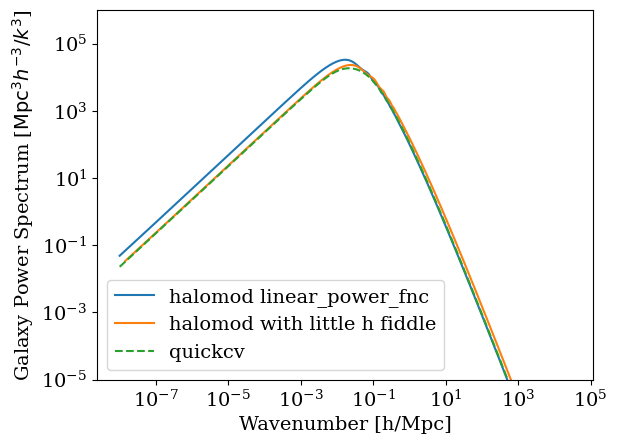

In [13]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
sig8 = 0.96 # use the same value as before to see if power spec matches
hm = DMHaloModel(cosmo_params={'H0':cosmo.H0, 'Om0':cosmo.Om0, 'Tcmb0':2.725}, sigma_8=sig8, n=1)

plt.plot(hm.k, hm.linear_power_fnc(hm.k), label="halomod linear_power_fnc")
plt.plot(hm.k/cosmo.h, hm.linear_power_fnc(hm.k)*cosmo.h, label="halomod with little h fiddle")
plt.plot(hm.k, pofk(hm.k), ls="--", label="quickcv")
#plt.plot(hm.k*cosmo.h, pofk(hm.k)/cosmo.h, ls="--", label="quickcv - with little h fiddle")
plt.xscale("log")
plt.yscale("log")
plt.ylim(1e-5, 1e6)
plt.legend()
plt.xlabel("Wavenumber [h/Mpc]")
plt.ylabel(r"Galaxy Power Spectrum [${\rm Mpc^3} h^{-3} / k^3$]");

# So are there little-h factors to worry about?
# Not when comparing with Moster - use halomod power as it is

In [14]:
# Switch to cosmology used in Moster et al. (2010)
cosmo = FlatLambdaCDM(H0=72, Om0=0.26, Tcmb0=2.725)
sig8 = 0.77
ns = 0.95
hm = DMHaloModel(cosmo_params={'H0':cosmo.H0, 'Om0':cosmo.Om0, 'Tcmb0':2.725}, sigma_8=sig8, n=ns)


In [15]:
# power spectrum integration function that uses the halomod power spectrum
def intpk4_hm(nsteps=200, rangemul=1, nmc=None, x1=10.1, x2=40.39, x3=650.7):
    
    if nmc==None:
        nmc = int(nsteps/3)
        
    #print(x1,x2,x3)
    
    k1max=(0.4+16/x1)*1.25*rangemul
    k2max=(0.4+16/x2)*1.25*rangemul
    k3max=(0.4+16/x3)*1.25*rangemul
    
    # sufficient to encompass entire region where sin^2=1/2 not adequate:
    # I don't understand what that means
    
    k1maxb=4.*np.pi/x1
    k2maxb=4.*np.pi/x2
    k3maxb=4.*np.pi/x3
    
    nstep2=nmc
    
    dk1=(k1max-k1maxb)/(nstep2-1)
    dk2=(k2max-k2maxb)/(nstep2-1)
    dk3=(k3max-k3maxb)/(nstep2-1)

    dk1b=k1maxb/(nsteps-1)
    dk2b=k2maxb/(nsteps-1)
    dk3b=k3maxb/(nsteps-1)

    k1arr=np.arange(nsteps+1)
    k2arr=k1arr*dk2b
    k3arr=k1arr*dk3b
    k1arr=k1arr*dk1b

    w1=np.sin(k1arr*x1)/k1arr/x1
    w1[np.isnan(w1)]=1.

    w2=np.sin(k2arr*x2)/k2arr/x2
    w2[np.isnan(w2)]=1.

    w3=np.sin(k3arr*x3)/k3arr/x3
    w3[np.isnan(w3)]=1.

    w1=w1**2
    w2=w2**2
    w3=w3**2
    
    k1b=np.exp(np.log(k1max/k1maxb)/nstep2*(np.arange(nstep2)+1.))*k1maxb
    k1arr=np.concatenate((k1arr,k1b))
    w1=np.concatenate((w1,(0.5)/x1**2/k1b**2))
    k2b=np.exp(np.log(k2max/k2maxb)/nstep2*(np.arange(nstep2)+1.))*k2maxb
    k2arr=np.concatenate((k2arr,k2b))
    w2=np.concatenate((w2,(0.5)/x2**2/k2b**2))
    k3b=np.exp(np.log(k3max/k3maxb)/nstep2*(np.arange(nstep2)+1.))*k3maxb
    k3arr=np.concatenate((k3arr,k3b))
    w3=np.concatenate((w3,(0.5)/x3**2/k3b**2)) # is this really supposed to be w1, not w3?? Doubtful

    integral=0.
    nsteps=nsteps+nstep2
    
    for i in range(nsteps):
        k1=k1arr[i]
        windowf=w1[i]
        dk1=(k1arr[int(min([i+1,nsteps]))]-k1arr[int(max([i-1,0]))])/2.
        ktot=k1**2

        ind2 = pylindgen((nsteps+1,nsteps+1)) % (nsteps+1)
        ind2a = ind2+1
        ind2b = ind2-1
        ind2a[ind2a>nsteps] = nsteps
        ind2b[ind2b<0] = 0
        dk2 = (k2arr[ind2a] - k2arr[ind2b]) / 2.
        ktot=ktot+k2arr[ind2]**2
        windowf=windowf*w2[ind2]
        ind2=1.

        ind3 = pylindgen((nsteps+1,nsteps+1)) // (nsteps+1)
        ind3a = ind3+1
        ind3b = ind3-1
        ind3a[ind3a>nsteps] = nsteps
        ind3b[ind3b<0] = 0
        dk3 = (k3arr[ind3a] - k3arr[ind3b]) / 2.
        ktot=ktot+k3arr[ind3]**2
        windowf=windowf*w3[ind3]
        ind3=1.
        ktot=np.sqrt(ktot)

        pk = hm.linear_power_fnc(ktot)
        if i==0:
            pk[0,0]=0.
        integral=integral+np.sum(pk*windowf*dk1*dk2*dk3)
    
    return integral/np.pi**3

In [46]:
# run a set to match Moster - use the EGS field
side1 = 10./60.
side2 = 70./60.
deltaz = 0.2
npoints = 200
bias = 1.

zvals = np.array([0.1,0.3,0.5,0.7,0.9,1.1,1.5,1.9,2.5,3.5])
cv_vals_hm = np.zeros_like(zvals)

for zi,za in enumerate(zvals):
    hm.z = za

    rza = cosmo.comoving_distance(za)
    rzmin = cosmo.comoving_distance(za-deltaz/2.)
    rzmax = cosmo.comoving_distance(za+deltaz/2.)
    
    x1a = (cosmo.kpc_comoving_per_arcmin(za) * side1 * 60. / 1000. / 2.)*cosmo.h
    x2a = (cosmo.kpc_comoving_per_arcmin(za) * side2 * 60. / 1000. / 2.)*cosmo.h
    x3a = (1.*(rzmax-rzmin)/2.)*cosmo.h
    cvi=intpk4_hm(x1=x1a.value,x2=x2a.value,x3=x3a.value,nsteps=npoints, rangemul=1)
    print(za,x1a.value, x2a.value, x3a.value, np.sqrt(cvi))
    print("\n")
    
    cv_vals_hm[zi] = np.sqrt(cvi)

/tmp/ipykernel_2354955/327392552.py:35: RuntimeWarning: invalid value encountered in divide
  w1=np.sin(k1arr*x1)/k1arr/x1
/tmp/ipykernel_2354955/327392552.py:38: RuntimeWarning: invalid value encountered in divide
  w2=np.sin(k2arr*x2)/k2arr/x2
/tmp/ipykernel_2354955/327392552.py:41: RuntimeWarning: invalid value encountered in divide
  w3=np.sin(k3arr*x3)/k3arr/x3


0.1 0.4273086921487758 2.9911608450414313 287.5572244669181 0.21563841108487022


0.3 1.2267803470106422 8.587462429074497 261.7860210176348 0.15961160401704858


0.5 1.9501664772859906 13.651165341001935 235.75964505325118 0.13329982131764406


0.7 2.5994322844242066 18.19602599096945 211.13714341010947 0.11640247353339626


0.9 3.1802008386926395 22.261405870848474 188.7991414870073 0.10427707950789182


1.1 3.6997099208264794 25.897969445785368 169.03707736145478 0.09513118774300826


1.5 4.584473462916896 32.091314240418264 136.84028343443956 0.08217672804933308


1.9 5.306523995480592 37.14566796836415 112.67606954644164 0.07334904166805586


2.5 6.169614587908371 43.187302115358605 86.94423360234312 0.06417304712530945


3.5 7.224010762991878 50.56807534094317 60.62712693676436 0.05421269606753539




[0.21563841 0.1596116  0.13329982 0.11640247 0.10427708 0.09513119
 0.08217673 0.07334904 0.06417305 0.0542127 ]
[0.99703944 0.98363776 0.96024135 0.9449971  0.93021401 0.92503838
 0.91266715 0.89980726 0.88822337 0.88540146]


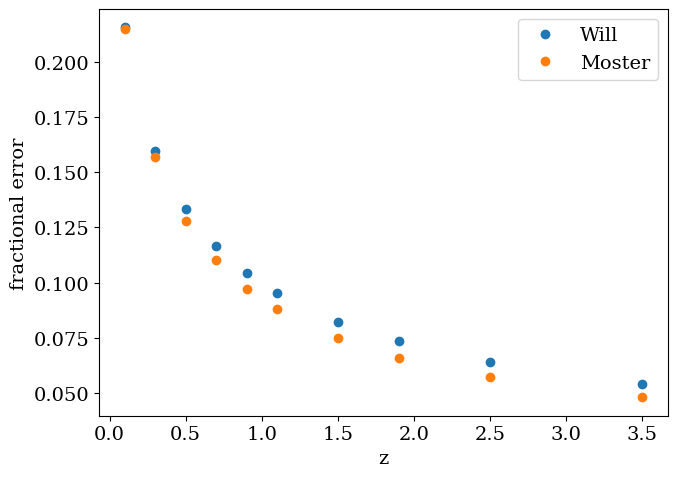

In [47]:
moster = np.array([0.215, 0.157, 0.128, 0.110, 0.097, 0.088, 0.075, 0.066, 0.057, 0.048])
# 0.120 should be 0.110 in the Moster result, I think

idl = np.array([0.221, 0.161, 0.128, 0.105, 0.089, 0.077, 0.0617, 0.053, 0.046, 0.047])
# ran the idl code on our cluster - had to fix some out-of-date bugs etc., got different results, but it's probably 
# due to trying to put the Moster cosmology in the IDL code

print(cv_vals_hm)
print(moster/cv_vals_hm)

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
ax.plot(zvals, cv_vals_hm, 'o', label='Will')
ax.plot(zvals, moster, 'o', label='Moster')
ax.set_xlabel(r'z')
ax.set_ylabel(r'fractional error')
ax.legend()
plt.tight_layout()
plt.show()

# COSMOS field
## Angular dimension: side 1= side 2 = 84 arcmin

In [48]:
# Now we can run the dz=0.002 sampling
# Use Planck15 cosmology
cosmo = Planck15
ns = 0.968
sig8 = 0.829
hm = DMHaloModel(cosmo_params={'H0':cosmo.H0, 'Om0':cosmo.Om0, 'Tcmb0':2.725}, sigma_8=sig8, n=ns)

# COSMOS field dimensions, which governs our redshift calib sample variance
side1 = 84./60.
side2 = 84./60.
deltaz = 0.002
npoints = 200
bias = 1.
zvals = np.arange(deltaz,3.6+deltaz,deltaz)

cv_vals_fine = np.zeros_like(zvals)

for zi,za in enumerate(zvals):
    
    hm.z = za
    rza = cosmo.comoving_distance(za)
    rzmin = cosmo.comoving_distance(za-deltaz/2.)
    rzmax = cosmo.comoving_distance(za+deltaz/2.)
    
    x1a = (cosmo.kpc_comoving_per_arcmin(za) * side1 * 60. / 1000. / 2.)*cosmo.h
    x2a = (cosmo.kpc_comoving_per_arcmin(za) * side2 * 60. / 1000. / 2.)*cosmo.h
    x3a = (1.*(rzmax-rzmin)/2.)*cosmo.h
    cvi=intpk4_hm(x1=x1a.value,x2=x2a.value,x3=x3a.value,nsteps=npoints, rangemul=1)
    
    cv_vals_fine[zi] = np.sqrt(cvi)

/tmp/ipykernel_2354955/327392552.py:35: RuntimeWarning: invalid value encountered in divide
  w1=np.sin(k1arr*x1)/k1arr/x1
/tmp/ipykernel_2354955/327392552.py:38: RuntimeWarning: invalid value encountered in divide
  w2=np.sin(k2arr*x2)/k2arr/x2
/tmp/ipykernel_2354955/327392552.py:41: RuntimeWarning: invalid value encountered in divide
  w3=np.sin(k3arr*x3)/k3arr/x3


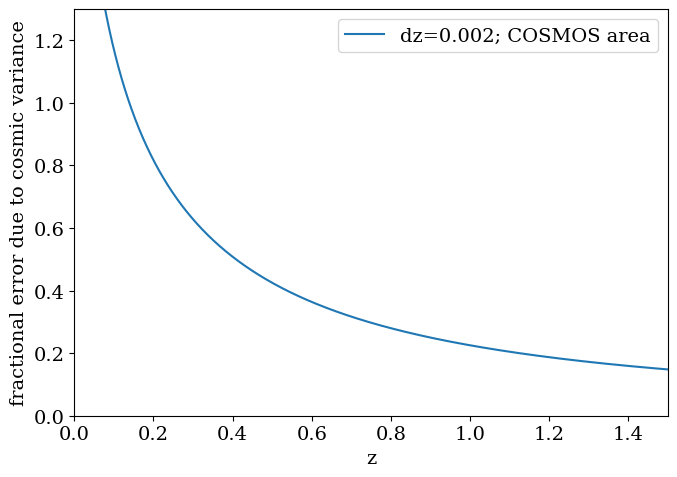

In [49]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
ax.plot(zvals, cv_vals_fine, '-', label=r'dz=0.002; COSMOS area')
ax.set_xlabel(r'z')
ax.set_ylabel(r'fractional error due to cosmic variance')
ax.legend()
ax.set_xlim([0.,1.5])
ax.set_ylim([0,1.3])
plt.tight_layout()
plt.show()

In [50]:
# COSMOS field dimensions, which governs our redshift calib sample variance
side1 = 84./60.
side2 = 84./60.
deltaz = 0.1
npoints = 200
bias = 1.
zvals = np.arange(deltaz,3.6+deltaz,deltaz)

cv_vals = np.zeros_like(zvals)

for zi,za in enumerate(zvals):
    
    hm.z = za
    rza = cosmo.comoving_distance(za)
    rzmin = cosmo.comoving_distance(za-deltaz/2.)
    rzmax = cosmo.comoving_distance(za+deltaz/2.)
    
    x1a = (cosmo.kpc_comoving_per_arcmin(za) * side1 * 60. / 1000. / 2.)*cosmo.h
    x2a = (cosmo.kpc_comoving_per_arcmin(za) * side2 * 60. / 1000. / 2.)*cosmo.h
    x3a = (1.*(rzmax-rzmin)/2.)*cosmo.h
    cvi=intpk4_hm(x1=x1a.value,x2=x2a.value,x3=x3a.value,nsteps=npoints, rangemul=1)
    
    cv_vals[zi] = np.sqrt(cvi)

/tmp/ipykernel_2354955/327392552.py:35: RuntimeWarning: invalid value encountered in divide
  w1=np.sin(k1arr*x1)/k1arr/x1
/tmp/ipykernel_2354955/327392552.py:38: RuntimeWarning: invalid value encountered in divide
  w2=np.sin(k2arr*x2)/k2arr/x2
/tmp/ipykernel_2354955/327392552.py:41: RuntimeWarning: invalid value encountered in divide
  w3=np.sin(k3arr*x3)/k3arr/x3


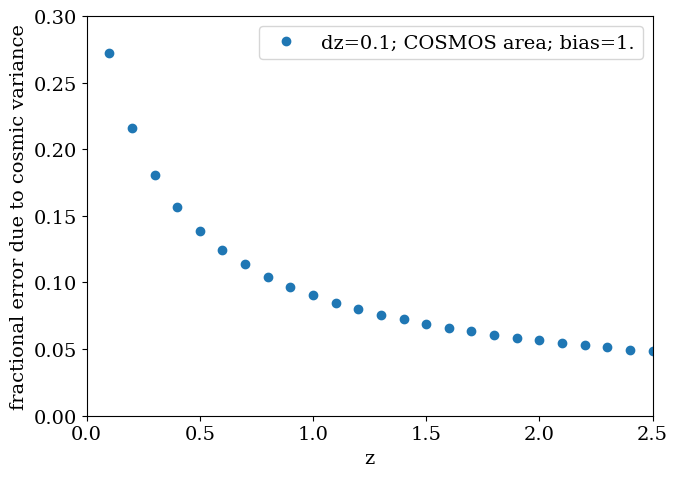

In [51]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
ax.plot(zvals, cv_vals, 'o', label=r'dz=0.1; COSMOS area; bias=1.')
ax.set_xlabel(r'z')
ax.set_ylabel(r'fractional error due to cosmic variance')
ax.legend()
ax.set_xlim([0.,2.5])
ax.set_ylim([0,0.3])
plt.tight_layout()
plt.show()

In [52]:
side1 = 84./60.
side2 = 84./60.
deltaz = 0.05
npoints = 200
bias = 1.
zvals = np.arange(deltaz,3.6+deltaz,deltaz)

cv_vals = np.zeros_like(zvals)

for zi,za in enumerate(zvals):
    
    hm.z = za
    rza = cosmo.comoving_distance(za)
    rzmin = cosmo.comoving_distance(za-deltaz/2.)
    rzmax = cosmo.comoving_distance(za+deltaz/2.)
    
    x1a = (cosmo.kpc_comoving_per_arcmin(za) * side1 * 60. / 1000. / 2.)*cosmo.h
    x2a = (cosmo.kpc_comoving_per_arcmin(za) * side2 * 60. / 1000. / 2.)*cosmo.h
    x3a = (1.*(rzmax-rzmin)/2.)*cosmo.h
    cvi=intpk4_hm(x1=x1a.value,x2=x2a.value,x3=x3a.value,nsteps=npoints, rangemul=1)
    
    cv_vals[zi] = np.sqrt(cvi)

/tmp/ipykernel_2354955/327392552.py:35: RuntimeWarning: invalid value encountered in divide
  w1=np.sin(k1arr*x1)/k1arr/x1
/tmp/ipykernel_2354955/327392552.py:38: RuntimeWarning: invalid value encountered in divide
  w2=np.sin(k2arr*x2)/k2arr/x2
/tmp/ipykernel_2354955/327392552.py:41: RuntimeWarning: invalid value encountered in divide
  w3=np.sin(k3arr*x3)/k3arr/x3


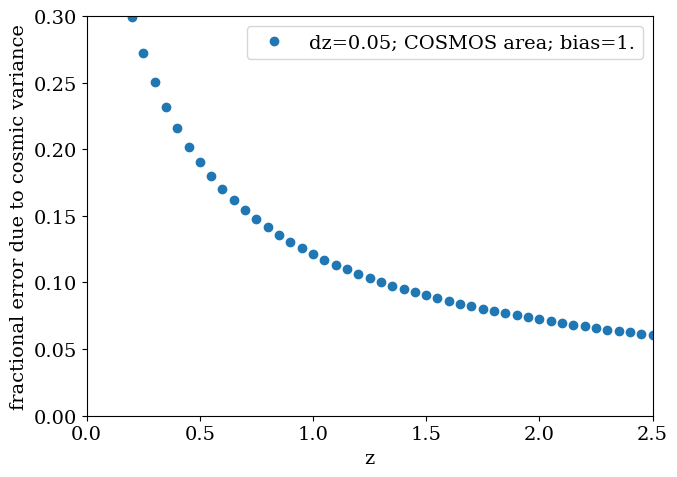

In [53]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
ax.plot(zvals, cv_vals, 'o', label=r'dz=0.05; COSMOS area; bias=1.')
ax.set_xlabel(r'z')
ax.set_ylabel(r'fractional error due to cosmic variance')
ax.legend()
ax.set_xlim([0.,2.5])
ax.set_ylim([0,0.3])
plt.tight_layout()
plt.show()

## Now I try with all the fields

In [16]:



# Field centers and areas from Hartley+2020
fields = {
    "SN-C3": {"RA": 52.6484, "Dec": -28.1000, "Area": 1.70},
    "SN-X3": {"RA": 36.4500, "Dec": -4.6000, "Area": 1.52},
    "SN-E2": {"RA": 9.5000, "Dec": -43.9980, "Area": 1.42},
    "COSMOS": {"RA": 150.1166, "Dec": 2.2058, "Area": 1.24}
}

# Constants
deltaz = 0.1
zvals = np.arange(deltaz, 3.6 + deltaz, deltaz)
bias = 1.0
npoints = 200

results_continuous = {}


for name, props in fields.items():
    ra_c = props["RA"]
    dec_c = props["Dec"]
    area_deg2 = props["Area"]

    ra_width_deg = np.sqrt(area_deg2)
    dec_width_deg = area_deg2 / ra_width_deg

    cv_vals = np.zeros_like(zvals)

    for zi, za in enumerate(zvals):
        hm.z = za  
        #line-of-sight comoving distances (in Mpc)
        rza = cosmo.comoving_distance(za)
        rzmin = cosmo.comoving_distance(za - deltaz / 2.0) 
        rzmax = cosmo.comoving_distance(za + deltaz / 2.0)

        # Convert angular size to comoving Mpc/h 
        x1a = (cosmo.kpc_comoving_per_arcmin(za) * ra_width_deg * 60. / 1000. / 2.)*cosmo.h 
        x2a = (cosmo.kpc_comoving_per_arcmin(za) * dec_width_deg * 60. / 1000. / 2.)*cosmo.h 
        x3a = (1.*(rzmax-rzmin)/2.)*cosmo.h

        # Compute cosmic variance using halomod-based integral
        #cvi = intpk4_hm(x1=x1a, x2=x2a, x3=x3a, nsteps=npoints, rangemul=1)
        cvi=intpk4_hm(x1=x1a.value,x2=x2a.value,x3=x3a.value,nsteps=npoints, rangemul=1)

        cv_vals[zi] = np.sqrt(cvi) 

    results_continuous[name] = {"z": zvals, "sigma": cv_vals}


/tmp/ipykernel_268352/327392552.py:35: RuntimeWarning: invalid value encountered in divide
  w1=np.sin(k1arr*x1)/k1arr/x1
/tmp/ipykernel_268352/327392552.py:38: RuntimeWarning: invalid value encountered in divide
  w2=np.sin(k2arr*x2)/k2arr/x2
/tmp/ipykernel_268352/327392552.py:41: RuntimeWarning: invalid value encountered in divide
  w3=np.sin(k3arr*x3)/k3arr/x3


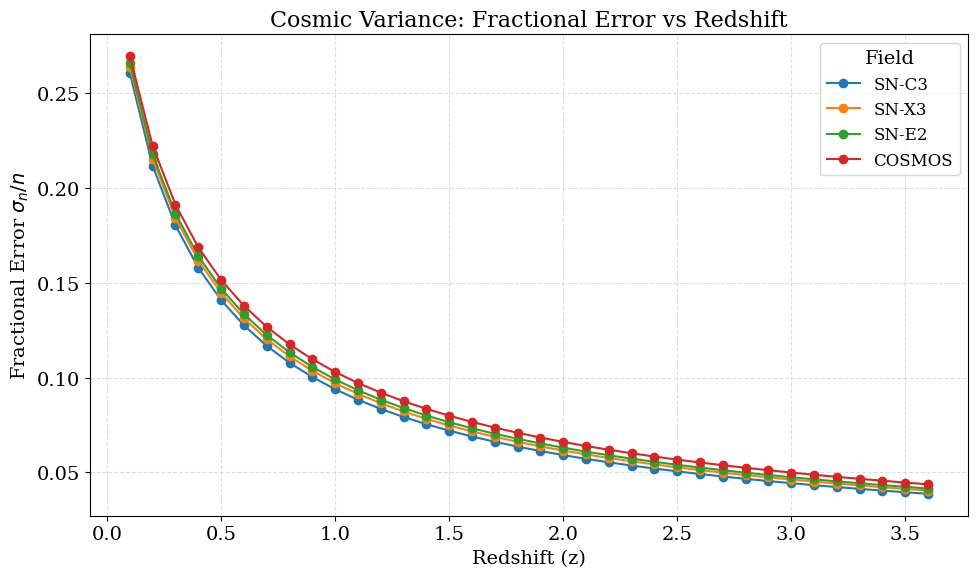

In [27]:
colors = {
    "SN-C3": "tab:blue",
    "SN-X3": "tab:orange",
    "COSMOS": "tab:red",
    "SN-E2": "tab:green"
}
plt.figure(figsize=(10, 6))
for field, data in results_continuous.items():
    plt.plot(data["z"], data["sigma"], marker='o', label=field, color=colors[field])


plt.xlabel("Redshift (z)", fontsize=14)
plt.ylabel(r"Fractional Error $\sigma_n / n$", fontsize=14)
plt.title("Cosmic Variance: Fractional Error vs Redshift", fontsize=16)
plt.legend(title="Field", fontsize=12)
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.tight_layout()
plt.savefig("cosmic_variance_vs_z.png")

plt.show()

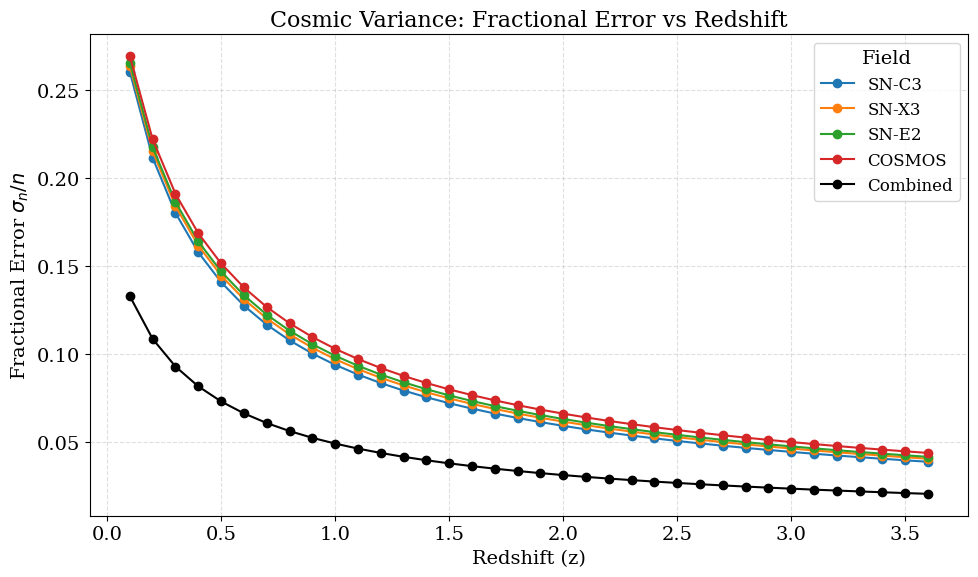

In [37]:
sigma2_total = np.zeros_like(zvals)

# For each redshift index
for zi in range(len(zvals)):
    numerator = 0.0
    denominator = 0.0

    for name, props in fields.items():
        area_deg2 = props["Area"]

        sigma_i = results_continuous[name]["sigma"][zi]
        numerator += (area_deg2**2) * (sigma_i**2)
        denominator += area_deg2

    sigma2_total[zi] = np.sum(numerator) / ((np.sum(denominator))**2)

# Now take sqrt to get total sigma
sigma_total = np.sqrt(sigma2_total)

combined_results = {
    "z": zvals,
    "sigma_total": sigma_total
}


colors = {
    "SN-C3": "tab:blue",
    "SN-X3": "tab:orange",
    "COSMOS": "tab:red",
    "SN-E2": "tab:green"
}

plt.figure(figsize=(10, 6))
for field, data in results_continuous.items():
    plt.plot(data["z"], data["sigma"], marker='o', label=field, color=colors[field])

plt.plot(combined_results["z"], combined_results["sigma_total"], marker='o', linestyle='-', color='black', label="Combined")

plt.xlabel("Redshift (z)", fontsize=14)
plt.ylabel(r"Fractional Error $\sigma_n / n$", fontsize=14)
plt.title("Cosmic Variance: Fractional Error vs Redshift", fontsize=16)
plt.legend(title="Field", fontsize=12)
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.tight_layout()
plt.savefig("cosmic_variance_vs_z_combined.png")
plt.show()


##  fractional error in number density (sigma_n / n) for a bias=1 sample (based on the matter power spectrum). 

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Your redshift bins centers (e.g., 0.1, 0.3, ...)
z_plot = [0.5*(z[0] + z[1]) for z in all_results.keys()]

# Previously calculated background fluctuations (δ_b)
# and their uncertainties, or fractional errors (approximate)
# Here, let's assume fractional errors are bias errors for illustration:
frac_err_b = np.array(global_bias_errors)  # relative error on δ_b approx
frac_err_dm = 0.1 * np.ones_like(delta_dm_vals)  # dummy ~10% error for DM fluctuations

# Plot measured fluctuations as fractional errors for comparison
plt.figure(figsize=(10, 6))

# Plot fields from correlation measurements (assuming results_continuous dict)
for field, data in results_continuous.items():
    plt.plot(data["z"], data["sigma"], marker='o', label=f"{field} (Moster et al.)", color=colors[field])

# Plot combined sigma_total from Moster et al. weighted sum
plt.plot(combined_results["z"], combined_results["sigma_total"], marker='o', linestyle='-', 
         color='black', label="Combined (Moster et al.)", linewidth=2)

# Overlay your measured fractional errors (or normalized fluctuations)
# Just for visualization, normalize delta_b_vals by their max to compare scales
normalized_delta_b = np.array(delta_b_vals) / np.max(delta_b_vals)
plt.plot(z_plot, normalized_delta_b, marker='s', linestyle='--', color='tab:purple', label="Measured δ_b (normalized)")

plt.xlabel("Redshift (z)", fontsize=14)
plt.ylabel(r"Fractional Error / Fluctuation Amplitude", fontsize=14)
plt.title("Comparison of Cosmic Variance / Density Fluctuations vs Redshift", fontsize=16)
plt.legend(title="Method/Field", fontsize=12)
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.tight_layout()
plt.show()


NameError: name 'all_results' is not defined